In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [3]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [4]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

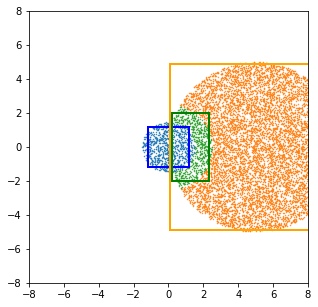

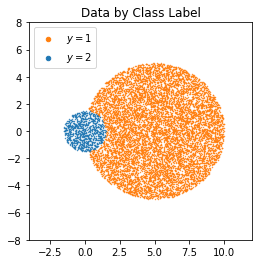

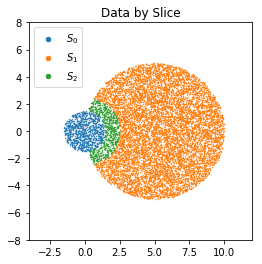

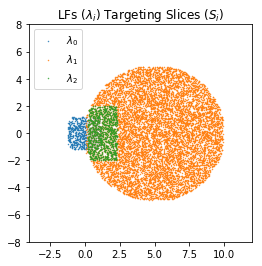

In [5]:
# from deathstar_data import generate_deathstar_data, generate_uniform_circle_data, get_circle_idx
from data_generators import generate_pacman_data
from synthetics_utils import shuffle_matrices, lf_circ_idx_for_slice_precision

config = {
    'N': 10000,
    'mus': np.array([[0,  0], [5, 0]]),
    'variances': [1.5, 5],
    'labels': [2, 1],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

X, Y, C, L = generate_pacman_data(config, plotting=True)

visualize_data(X, Y, C, L)

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [6]:
from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model

#### Setup data

In [7]:
X, Y, Z, L = generate_pacman_data(config)
target_lfs_idx = [3]
Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

# add peppering
from metal.contrib.slicing.utils import add_pepper
pepper = 0.1

In [8]:
Ls[0] = add_pepper(Ls[0], pepper)        

# replace GT with weak labels
label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])
Y_train = label_model.predict_proba(Ls[0])
Ys[0] = Y_train

# for testing LFs
X_test = torch.Tensor(Xs[2])
L_test = Ls[2]

Added pepper=0.1 random negatives on 3/3 LFs


#### Test `SliceDPModel`
NOTE: `slice_weight = 1.0`

In [9]:
import torch.nn.functional as F
from metal.metrics import accuracy_score
train_kwargs = {
    "verbose": True,
    "n_epochs": 20,
    "lr": 0.005,
    "l2": 1e-7,
}
sm_dp_config = {
    'slice_kwargs': {
        'r': 5,
        'slice_weight': 1.0,
        'reweight': True
    },
    'train_kwargs': train_kwargs,
    'input_module_class': MLPModule,
    'input_module_init_kwargs': {
        'input_dim': 2,
        'output_dim': 5,
        'middle_dims': [5],
        'bias': True
    }
}
model = train_slice_dp(sm_dp_config, Ls, Xs, Ys, Zs)
print(model)

# L_preds = model.predict_L_proba(X_test)
L_preds = F.sigmoid(model.forward_L(X_test)).data.cpu().numpy()


preds = (L_preds > 0.5) * 1
L_gt = L_test.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.sum(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))
print ('accuracy over LF2:', accuracy_score(L_gt[:, 2], preds[:, 2]))

Slice Heads:
Reweighting: True
L_weights: tensor([[1.],
        [1.],
        [1.]])
Slice Weight: 1.0
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
)
L_head: Linear(in_features=5, out_features=3, bias=False)
Y_head: Linear(in_features=10, out_features=2, bias=True)
Criteria: BCEWithLogitsLoss() SoftCrossEntropyLoss()



Saving model at iteration 0 with best score 0.056
[E:0]	Train Loss: 0.255	Dev accuracy: 0.056



[E:1]	Train Loss: 0.130	Dev accuracy: 0.044



Saving model at iteration 2 with best score 0.086
[E:2]	Train Loss: 0.122	Dev accuracy: 0.086



Saving model at iteration 3 with best score 0.483
[E:3]	Train Loss: 0.117	Dev accuracy: 0.483



Saving model at iteration 4 with best score 0.491
[E:4]	Train Loss: 0.114	Dev accuracy: 0.491



Saving model at iteration 5 with best score 0.519
[E:5]	Train Loss: 0.110	Dev accuracy: 0.519



Saving model at iteration 6 with best score 0.520
[E:6]	Train Loss: 0.107	Dev accuracy: 0.520



[E:7]	Train Loss: 0.104	Dev accuracy: 0.500



[E:8]	Train Loss: 0.100	Dev accuracy: 0.490



[E:9]	Train Loss: 0.096	Dev accuracy: 0.503



[E:10]	Train Loss: 0.092	Dev accuracy: 0.513



[E:11]	Train Loss: 0.088	Dev accuracy: 0.480



[E:12]	Train Loss: 0.084	Dev accuracy: 0.490



[E:13]	Train Loss: 0.081	Dev accuracy: 0.491



[E:14]	Train Loss: 0.079	Dev accuracy: 0.505



[E:15]	Train Loss: 0.077	Dev accuracy: 0.488



[E:16]	Train Loss: 0.075	Dev accuracy: 0.477



[E:17]	Train Loss: 0.074	Dev accuracy: 0.497



[E:18]	Train Loss: 0.073	Dev accuracy: 0.507



[E:19]	Train Loss: 0.072	Dev accuracy: 0.493
Restoring best model from iteration 6 with score 0.520
Finished Training
Accuracy: 0.500
        y=1    y=2   
 l=1   1201    123   
 l=2   1179    101   
SliceDPModel(
  (network): Sequential(
    (0): MLPModule(
      (input_layer): Sequential(
        (0): Linear(in_features=2, out_features=5, bias=True)
        (1): ReLU()
        (2): Linear(in_features=5, out_features=5, bias=True)
        (3): ReLU()
      )
    )
  )
  (criteria): SoftCrossEntropyLoss()
  (criteria_L): BCEWithLogitsLoss()
  (criteria_Y): SoftCrossEntropyLoss()
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (Y_head): Linear(in_features=10, out_features=2, bias=True)
)
predicted L distribution: [ 110 2603  263]
accuracy over LF0: 0.9642719938532462
accuracy over LF1: 0.9496734537072609
accuracy over LF2: 0.9585094122166731


#### Test `SliceHatModel`
NOTE: `slice_weight = 1.0`

In [10]:
end_model_init_kwargs = {
    "layer_out_dims": [2, 5, 5, 2]
}
sm_hat_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 1.0,
        "reweight": True,
    }
}

model = train_model(sm_hat_config, Ls, Xs, Ys, Zs, model_key="hat")
print (model)

# L_preds = model.predict_L_proba(X_test)
L_preds = F.sigmoid(abs(model.L_head(model.body(X_test))))

# thresh = 0.3
# pos_preds = (L_preds > 0.5 + thresh)
# neg_preds = (L_preds < 0.5 - thresh)

# preds = np.zeros(L_gt.shape)
# preds[pos_preds] = 1
# preds[neg_preds] = 2

L_gt = L_test.copy()

preds = (L_preds > 0.5) * 1
L_gt = L_test.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.unique(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))
print ('accuracy over LF2:', accuracy_score(L_gt[:, 2], preds[:, 2]))


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
)

Saving model at iteration 0 with best score 0.914
[E:0]	Train Loss: 0.000	Dev accuracy: 0.914
[E:1]	Train Loss: 0.000	Dev accuracy: 0.914
[E:2]	Train Loss: 0.000	Dev accuracy: 0.914
[E:3]	Train Loss: 0.000	Dev accuracy: 0.914
[E:4]	Train Loss: 0.000	Dev accuracy: 0.914
[E:5]	Tr

#### Test `SliceOnlineModel`
NOTE: `L_head_weight = 1.0`, `Y_head_weight = 0.0`

In [11]:
sm_on_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_head_weight": 1.0,
        "Y_head_weight": 0.0 
    }
}
model = train_model(sm_on_config, Ls, Xs, Ys, Zs, model_key="online")
print (model)

# L_preds = model.predict_L_proba(X_test)
L_preds = F.sigmoid(abs(model.L_head(model.body(X_test))))

# thresh = 0.3
# pos_preds = (L_preds > 0.5 + thresh)
# neg_preds = (L_preds < 0.5 - thresh)

# preds = np.zeros(L_gt.shape)
# preds[pos_preds] = 1
# preds[neg_preds] = 2

L_gt = L_test.copy()

preds = (L_preds > 0.5) * 1
L_gt = L_test.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.unique(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))
print ('accuracy over LF2:', accuracy_score(L_gt[:, 2], preds[:, 2]))


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Resetting base model parameters
SliceOnlineModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=10, out_features=1, bias=True)
)

Saving model at iteration 0 with best score 0.914
[E:0]	Train Loss: 0.042	Dev accuracy: 0.914
Saving model at

### Compare EndModel to AttentionModel

In [12]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
train_kwargs = {
    "verbose": True,
    "n_epochs": 30,
    "lr": 0.001,
    "l2": 0,
}
end_model_init_kwargs = {
    "layer_out_dims": [2, 5, 5, 2],
    **train_kwargs
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5
}

print("WARNING: Pay attention to slice weight!")
sm_hat_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
        "reweight": True,
    }
}

sm_on_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_head_weight": 0.1,
        "Y_head_weight": 0.1 
    }
}

sm_dp_config = {
    'slice_kwargs': {
        'r': 5,
        'slice_weight': 0.1,
        'reweight': True
    },
    'train_kwargs': train_kwargs,
    'input_module_class': MLPModule,
    'input_module_init_kwargs': {
        'input_dim': 2,
        'output_dim': 5,
        'middle_dims': [5],
        'bias': True
    }
}

In [13]:
%%time
from collections import defaultdict

model_configs = {
    "UNI": uni_config,
    "UP": up_config,
    "MoE": moe_config,
    "DP": dp_config,
    "SM_HAT": sm_hat_config,
    "SM_ON": sm_on_config,
    'SM_DP': sm_dp_config
}

NUM_TRIALS = 1
NUM_SLICES = 3
K = 2
N = 10000
m = 3
pepper = 0.1
print(f"Pepper: {pepper}")
# A base to add to trial number to set a unique seed for each trial
salt = 42 #np.random.randint(1e6)
print(f"Salt: {salt}")


history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    Z_kwargs = {'num_slices': NUM_SLICES}
    X, Y, Z, L = generate_pacman_data(config)
    target_lfs_idx = [0]

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    L_train_raw = Ls[0].copy() # TEMP
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI" or model_name.startswith("UP"):
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])            
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            L_weights = list(np.ones(m))
            model = train_model(model_config, Ls, Xs, Ys, Zs, L_weights)
        elif model_name == "UP":
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              [target_lfs_idx], verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM_HAT":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="hat")
        elif model_name == "SM_ON":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="online")
        elif model_name == 'SM_DP':
            model = train_slice_dp(model_config, Ls, Xs, Ys, Zs)
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")

        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

Pepper: 0.1
Salt: 42
[Trial 0]
---------- Training UNI ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.922
[E:0]	Train Loss: 0.270	Dev accuracy: 0.922
[E:1]	Train Loss: 0.108	Dev accuracy: 0.922
[E:2]	Train Loss: 0.079	Dev accuracy: 0.922
[E:3]	Train Loss: 0.071	Dev accuracy: 0.922
Saving model at iteration 4 with best score 0.947
[E:4]	Train Loss: 0.067	Dev accuracy: 0.947
Saving model at iteration 5 with best score 0.951
[E:5]	Train Loss: 0.065	Dev accuracy: 0.951
Saving model at iteration 6 with best score 0.954
[E:6]	Train Loss: 0.062	Dev accuracy: 0.954
Saving model at iteration 7 with best score 0.955
[E:7]	Train Loss: 0

Saving model at iteration 0 with best score 0.184
[E:0]	Train Loss: 0.719	Dev accuracy: 0.184
[E:1]	Train Loss: 0.650	Dev accuracy: 0.150
[E:2]	Train Loss: 0.648	Dev accuracy: 0.117
[E:3]	Train Loss: 0.647	Dev accuracy: 0.080
[E:4]	Train Loss: 0.646	Dev accuracy: 0.078
[E:5]	Train Loss: 0.646	Dev accuracy: 0.078
[E:6]	Train Loss: 0.645	Dev accuracy: 0.078
[E:7]	Train Loss: 0.645	Dev accuracy: 0.078
[E:8]	Train Loss: 0.645	Dev accuracy: 0.078
[E:9]	Train Loss: 0.644	Dev accuracy: 0.078
[E:10]	Train Loss: 0.644	Dev accuracy: 0.078
[E:11]	Train Loss: 0.644	Dev accuracy: 0.078
[E:12]	Train Loss: 0.644	Dev accuracy: 0.078
[E:13]	Train Loss: 0.643	Dev accuracy: 0.078
[E:14]	Train Loss: 0.643	Dev accuracy: 0.078
[E:15]	Train Loss: 0.643	Dev accuracy: 0.078
[E:16]	Train Loss: 0.643	Dev accuracy: 0.078
[E:17]	Train Loss: 0.643	Dev accuracy: 0.078
[E:18]	Train Loss: 0.643	Dev accuracy: 0.078
[E:19]	Train Loss: 0.643	Dev accuracy: 0.078
[E:20]	Train Loss: 0.643	Dev accuracy: 0.078
[E:21]	Train Lo

Saving model at iteration 2 with best score 0.927
[E:2]	Train Loss: 0.171	Dev accuracy: 0.927
Saving model at iteration 3 with best score 0.940
[E:3]	Train Loss: 0.158	Dev accuracy: 0.940
Saving model at iteration 4 with best score 0.944
[E:4]	Train Loss: 0.153	Dev accuracy: 0.944
Saving model at iteration 5 with best score 0.947
[E:5]	Train Loss: 0.150	Dev accuracy: 0.947
Saving model at iteration 6 with best score 0.948
[E:6]	Train Loss: 0.148	Dev accuracy: 0.948
Saving model at iteration 7 with best score 0.949
[E:7]	Train Loss: 0.146	Dev accuracy: 0.949
[E:8]	Train Loss: 0.145	Dev accuracy: 0.949
[E:9]	Train Loss: 0.144	Dev accuracy: 0.949
[E:10]	Train Loss: 0.143	Dev accuracy: 0.949
[E:11]	Train Loss: 0.142	Dev accuracy: 0.949
[E:12]	Train Loss: 0.142	Dev accuracy: 0.949
[E:13]	Train Loss: 0.142	Dev accuracy: 0.949
[E:14]	Train Loss: 0.142	Dev accuracy: 0.949
[E:15]	Train Loss: 0.142	Dev accuracy: 0.949
[E:16]	Train Loss: 0.142	Dev accuracy: 0.949
[E:17]	Train Loss: 0.142	Dev accu


Saving model at iteration 0 with best score 0.922
[E:0]	Train Loss: 14.251	Dev accuracy: 0.922



[E:1]	Train Loss: 5.731	Dev accuracy: 0.922



[E:2]	Train Loss: 5.194	Dev accuracy: 0.922



Saving model at iteration 3 with best score 0.932
[E:3]	Train Loss: 5.061	Dev accuracy: 0.932



Saving model at iteration 4 with best score 0.936
[E:4]	Train Loss: 4.968	Dev accuracy: 0.936



Saving model at iteration 5 with best score 0.936
[E:5]	Train Loss: 4.890	Dev accuracy: 0.936



Saving model at iteration 6 with best score 0.938
[E:6]	Train Loss: 4.829	Dev accuracy: 0.938



[E:7]	Train Loss: 4.778	Dev accuracy: 0.937



[E:8]	Train Loss: 4.735	Dev accuracy: 0.938



[E:9]	Train Loss: 4.705	Dev accuracy: 0.938



Saving model at iteration 10 with best score 0.939
[E:10]	Train Loss: 4.680	Dev accuracy: 0.939



[E:11]	Train Loss: 4.660	Dev accuracy: 0.938



[E:12]	Train Loss: 4.645	Dev accuracy: 0.938



[E:13]	Train Loss: 4.632	Dev accuracy: 0.938



[E:14]	Train Loss: 4.630	Dev accuracy: 0.938



[E:15]	Train Loss: 4.617	Dev accuracy: 0.938



[E:16]	Train Loss: 4.613	Dev accuracy: 0.938



[E:17]	Train Loss: 4.605	Dev accuracy: 0.938



[E:18]	Train Loss: 4.599	Dev accuracy: 0.938



[E:19]	Train Loss: 4.592	Dev accuracy: 0.938



Saving model at iteration 20 with best score 0.939
[E:20]	Train Loss: 4.587	Dev accuracy: 0.939



[E:21]	Train Loss: 4.583	Dev accuracy: 0.938



[E:22]	Train Loss: 4.575	Dev accuracy: 0.939



[E:23]	Train Loss: 4.571	Dev accuracy: 0.938



[E:24]	Train Loss: 4.569	Dev accuracy: 0.938



[E:25]	Train Loss: 4.565	Dev accuracy: 0.939



[E:26]	Train Loss: 4.561	Dev accuracy: 0.939



[E:27]	Train Loss: 4.561	Dev accuracy: 0.939



[E:28]	Train Loss: 4.557	Dev accuracy: 0.939



[E:29]	Train Loss: 4.557	Dev accuracy: 0.939
Restoring best model from iteration 20 with score 0.939
Finished Training
Accuracy: 0.939
        y=1    y=2   
 l=1   2400    159   
 l=2     0     43    
CPU times: user 2min 12s, sys: 4 s, total: 2min 16s
Wall time: 2min 26s


In [14]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=1):


,UNI,UP,MoE,DP,SM_HAT,SM_ON,SM_DP
all,0.956589,0.090280,0.343834,0.951210,0.947753,0.953515,0.932770
slice_0,0.519149,1.000000,0.672340,0.459574,0.421277,0.485106,0.255319
slice_1,1.000000,0.000000,0.409851,1.000000,1.000000,1.000000,1.000000
slice_2,1.000000,0.000000,0.329032,1.000000,1.000000,1.000000,1.000000
slice_avg,0.839716,0.333333,0.470408,0.819858,0.807092,0.828369,0.751773
